In [1]:
from bs4 import BeautifulSoup as bs
from io import BytesIO
from PIL import Image
import base64
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.applications import ResNet50

## Image acquisition
This section consists of three main operations:

* First, the base64 image is extracted from the xml.

* Then these strings are transformed into images (PNG).

* These images are read and transformed into matrixes with which the model will eventually be able to work.

NOTE: **This section should only be executed once**. The purpose of this section is to get the images from the XML, once acquired you just have to browse the images directory to get them.


At the beginning of this section a function was written to be able to transform the images to a dataframe just by calling it.

In [2]:
def getImgFromDirectory(directory, image_size, convert): #"RGB" "L"
    img_matrix = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = Image.open(os.path.join(directory, filename)).resize(image_size)
            image_array = np.array(image.convert(convert))
            img_matrix.append(image_array)

    return np.stack(img_matrix, axis=0)

### Extract Base64 image from xml file 

BeautifulSoup is a Python library used for web scraping purposes to extract data from HTML and XML files. It is designed to make parsing HTML and XML documents simple and easy.

First we read all the lines of the file `SignosDistintivos.xml` (that`s why the r).
 
We use the bs() function to have a BeautifulSoup object with which we have access to different functions like `find()`, `find_all()` and `select()`.

In [2]:
def getXMLContent(fileName):
    content = []
    # Read the XML file
    with open(fileName, "r") as file:
        # Read each line in the file, readlines() returns a list of lines
        content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

    return bs_content

# bs_content = getXMLContent('SignosDistintivos.xml')

c:\ProgramData\Anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Usando la función `find_all()` BeatifulSoup nos entrega todas las etiquetas especificadas, en este caso las etiquetas "imagen".

Then we generate a txt file to be able to write only the content of the "image" tag.

In each line of the file there is a base64 image

In [3]:
def writeBase64Img2TxtFile(fileName, bs_content):
    f = open(fileName,"w+")

    images = bs_content.find_all('imagen')

    for image in images:
        f.write(image.text + "\n")
        # print(image.text)

    f.close()
    return images

# images = writeBase64Img2TxtFile('SignosDistintivos_b64.txt', bs_content)

### Base64 to PNG images

Using the same object we iterate, decode the base64 image and save it in the Images folder.

In [ ]:
def b64ToImg(images):
    i = 0

    for image in images:
        base64_string = image.text

        # Decode the base64 string and create a PIL Image object
        image_data = BytesIO(base64.b64decode(base64_string))
        image = Image.open(image_data)

        # Save the image as a PNG file
        image.save("img_sample/output_{0}.png".format(i), "PNG")
        i += 1

# base64ToImg(images)

### PNG image to matrix

The "L" argument in the `convert()` method stands for "Luminance" and is used to convert the image to grayscale by calculating the luminance of each pixel. Luminance is a measure of the brightness of a color and is calculated using the formula:

$$ Luminance = 0.299 * R + 0.587 * G + 0.114 * B $$

where R, G, and B are the red, green, and blue color components of the pixel. By using the "L" argument with the `convert()` method, the image is converted to grayscale by replacing each pixel's color value with its corresponding luminance value.

We make an adjustment to the size of the images so that they are all the same size 64x64, this so that, once vectorized, they can be saved in a dataframe without having null data.

In [ ]:
'''
# Define the directory containing the images
directory = "images"

# Define the desired image size (width x height)
image_size = (64, 64)

# Create an empty list to store the image matrices
image_matrices = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Open the image and resize it to the desired size
        image = Image.open(os.path.join(directory, filename)).resize(image_size)
        # Convert the image to a grayscale numpy array and append it to the list
        image_array = np.array(image.convert("L"))
        image_matrices.append(image_array)

# Stack the image matrices into a single 3D numpy array
image_matrix = np.stack(image_matrices, axis=0)

# Print the shape of the image matrix
print("Image matrix shape:", image_matrix.shape)
'''

Image matrix shape: (8755, 64, 64)


We display the image using a matplotlib heat map.

(-0.5, 63.5, 63.5, -0.5)

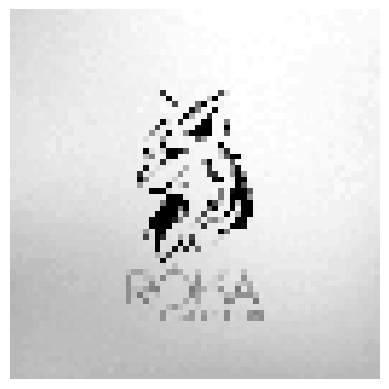

In [ ]:
# plt.imshow(image_matrix[1], cmap='gray')
# plt.axis('off')

### Matrix to Vector


Using the object `image_matrix` that contains all images in matrix form

For some strange reason it is changing the values of the images, at least it preserves the shape.
It's as if it subtracts 255 from all the values of the vectorized images.

It is important to note that this change happens when it becomes DataFrame, when it is flattened it keeps the original values.

In [ ]:
image_matrix = getImgFromDirectory("images", (64, 64), "L")

vectors = [m.flatten() for m in image_matrix]

# create a Pandas DataFrame from the list of vectors
data = pd.DataFrame(vectors, dtype=int)
data.head()


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-50,-48,-46,-46,-46,-46,-42,-40,-39,-39,...,-76,-76,-76,-76,-76,-80,-80,-80,-80,-80
1,-49,-49,-49,-46,-43,-43,-43,-41,-41,-41,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
vectors[:5]

[array([206, 208, 210, ..., 176, 176, 176], dtype=uint8),
 array([207, 207, 207, ..., 179, 179, 179], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)]

(-0.5, 63.5, 63.5, -0.5)

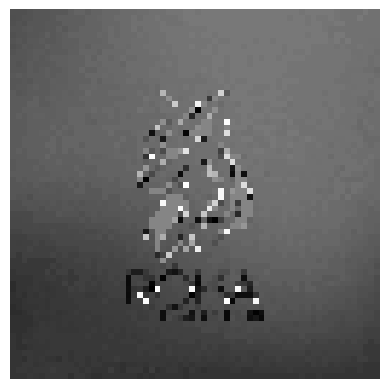

In [ ]:
test = (np.array(data.iloc[[1],:])).reshape(64, -1)
plt.imshow(test, cmap='gray')
plt.axis('off')


## Euclidean Distance (All)

The Euclidean distance is a measure of the distance between two points in Euclidean space. It is defined as the length of the shortest path between the two points, which is a straight line segment.

In the context of machine learning and data science, the Euclidean distance is often used as a metric to compare the similarity or dissimilarity between two vectors. Given two vectors of the same dimension, the Euclidean distance between them is calculated by taking the square root of the sum of the squared differences between each corresponding element of the vectors

$$ d(x,y) = sqrt(sum((x[i]-y[i])^2) for i in range(n)) $$


In [4]:
vectors = getImgFromDirectory(directory="images", image_size=(100, 100), convert="RGB")
print("vectors' lenght:", len(vectors))

vectors' lenght: 8755


In [6]:
vectors[12].shape

(100, 100, 3)

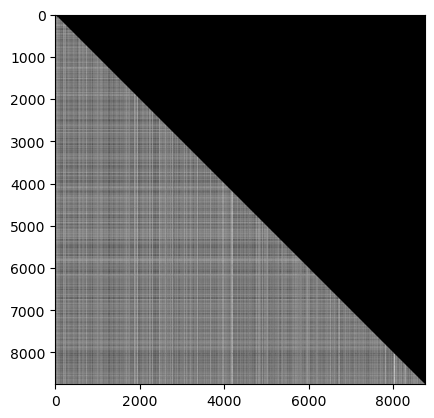

In [9]:
eu_matrix = np.zeros((len(vectors), len(vectors)))

for vectorX in range(len(vectors)):
    for vectorY in range(vectorX):
        eu_matrix[vectorX, vectorY] = np.linalg.norm(vectors[vectorX] - vectors[vectorY])

plt.imshow(eu_matrix, cmap='gray')

Once we have calculated all the Euclidean distances, we can use the results to validate our hypothesis. We can identify a few examples with the greatest distances and the shortest distances to determine if the images are more similar when the Euclidean distance is lower.

Also we are not counting the distnaces that are 0.

The parameter of the getTuple function are:
* matrix: it referes to the matrix where we are going to check the euclidian distances
* num_tuples: it refers to the number of random tuples we going to check
* num_results: it refers to the number of tuples we are going to get, we check among the num_tuples tuples and we keep num_results
* condition: it referes to what we want out of the tuples, if we want the greates distances or the shortest

In [25]:
## final
def getTuples(matrix, num_tuples,  num_result, condition= 'smaller'):
  result = np.ones(num_result) * (float('inf') if condition == 'smaller' else float(-1))
  final_result = np.array([[0, 0] for _ in range(num_result)])
  
  indexes = np.random.randint(0, len(matrix), size=(num_tuples, 2))
  # print(indexes)
  # for x1, y1 in indexes:
  #   print(matrix[x1][y1])

  for i, (x, y) in enumerate(indexes):
    value = matrix[x, y]

    biggest_value = np.max(result) if condition == 'smaller' else np.min(result)
    biggest_index = np.where(result == biggest_value)[0][0]

    if value != 0 and not np.any(np.isin(result, value)):
      # print('not 0 either is in result array')
      if condition == 'smaller':
        if value < biggest_value:
          result[biggest_index] = value
          final_result[biggest_index] = (x, y)
      elif condition == 'greater':
        if value > biggest_value:
          result[biggest_index] = value
          final_result[biggest_index] = (x, y)
      else:
        return

  return final_result, result

We are going to get 1000 random tuples, and out of them we are going to keep 20 of them for both greatest distances and shortest ones, in other words out of the 1000 sample we are going to get either the greatest ones or the shortest ones.

**It's important to notice that everytime we run the function it gets us a new sample, the sample to get the greatest and shortest distances are different**

In [28]:
max_tuples, max_values = getTuples(matrix= eu_matrix, 
                                   num_tuples= 8000, 
                                   num_result= 400, 
                                   condition= 'greater')

min_tuples, min_values = getTuples(matrix= eu_matrix,
                                   num_tuples= 8000,
                                   num_result= 400, 
                                   condition= 'smaller')

print('len of max_tuples:', len(max_tuples))
print('len of min_tuples:', len(min_tuples))

len of max_tuples: 400
len of min_tuples: 400


Some of the results

In [29]:
max_mean = np.mean(max_values)
max_std_dev = np.std(max_values)

print('mean of max_tuples:', max_mean)
print('std deviation of max_tuples:', max_std_dev)

min_mean = np.mean(min_values)
min_std_dev = np.std(min_values)

print('\nmean of min_tuples:', min_mean)
print('std deviation of min_tuples:', min_std_dev)

mean of max_tuples: 37534.895486756315
std deviation of max_tuples: 1959.5829539166286

mean of min_tuples: 10575.168952155323
std deviation of min_tuples: 1498.991739760476


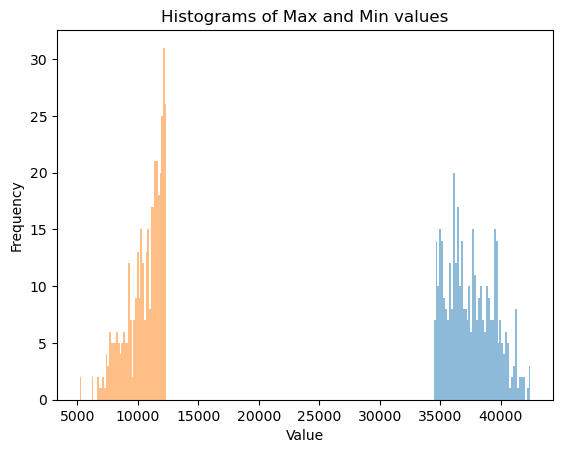

In [30]:
plt.hist(max_values, bins=50, alpha=0.5, label='Max distances')
plt.hist(min_values, bins=50, alpha=0.5, label='Min distances')

# Add a legend and labels
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Max and Min values')

# Show the plot
plt.show()

In [56]:
max_tuples[np.where(max_values == np.max(max_values))[0][0]]

3014

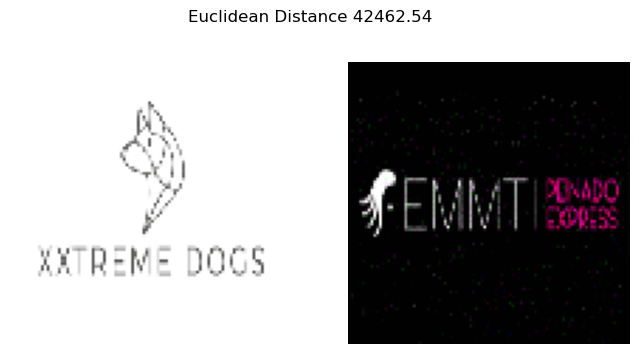

In [63]:
greatest_distance = max_tuples[np.where(max_values == np.max(max_values))[0][0]]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(vectors[greatest_distance[0]], cmap='Reds')
axs[0].axis('off')

axs[1].imshow(vectors[greatest_distance[1]], cmap='Reds')
axs[1].axis('off')

fig.suptitle('Euclidean Distance {0:.2f}'.format(eu_matrix[greatest_distance[0]][greatest_distance[1]]))

plt.show()

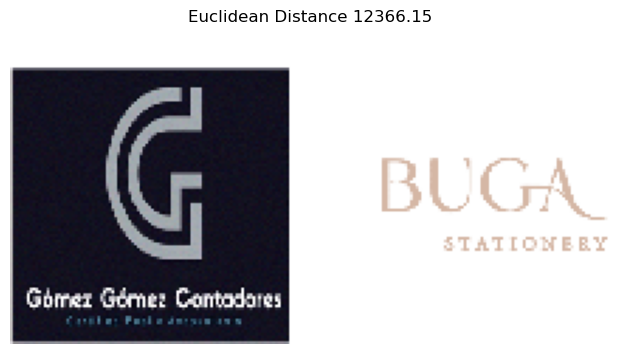

In [64]:
shortest_distance = min_tuples[np.where(min_values == np.max(min_values))[0][0]]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(vectors[shortest_distance[0]], cmap='Reds')
axs[0].axis('off')

axs[1].imshow(vectors[shortest_distance[1]], cmap='Reds')
axs[1].axis('off')

fig.suptitle('Euclidean Distance {0:.2f}'.format(eu_matrix[shortest_distance[0]][shortest_distance[1]]))

plt.show()

## Euclidean Distance (Sample)

### Sample Acquisition

The sample has been previously separated in order to test the hypothesis. We separated 22 images, some of which look similar and some of which are completely unrelated.

In [8]:
def getEuclideanDistance(img_matrix):
    eu_matrix = np.zeros((len(img_matrix), len(img_matrix)))

    for vectorX in range(len(img_matrix)):
        for vectorY in range(len(vectorX)):
            eu_matrix[vectorX, vectorY] = np.linalg.norm(img_matrix[vectorX] - img_matrix[vectorY])

    return eu_matrix

In [7]:
def getEuclideanDistanceAll(img_matrix):
    eu_matrix = np.zeros((len(img_matrix), len(img_matrix)))

    for vectorX in range(len(img_matrix)):
        for vectorY in range(len(img_matrix)):
            eu_matrix[vectorX, vectorY] = np.linalg.norm(img_matrix[vectorX] - img_matrix[vectorY])

    return eu_matrix

Using the getImgFromDirectory *from the PNG image to matrix section* we get the sample from the img_sample directory with a 1000x1000 resolution and 3 dimension (RGB)

In [6]:
image_matrix_sample_RGB = getImgFromDirectory(directory= "img_sample", image_size= (1000, 1000), convert= "RGB")

print("Image matrix shape:", image_matrix_sample_RGB.shape)

Image matrix shape: (22, 1000, 1000, 3)


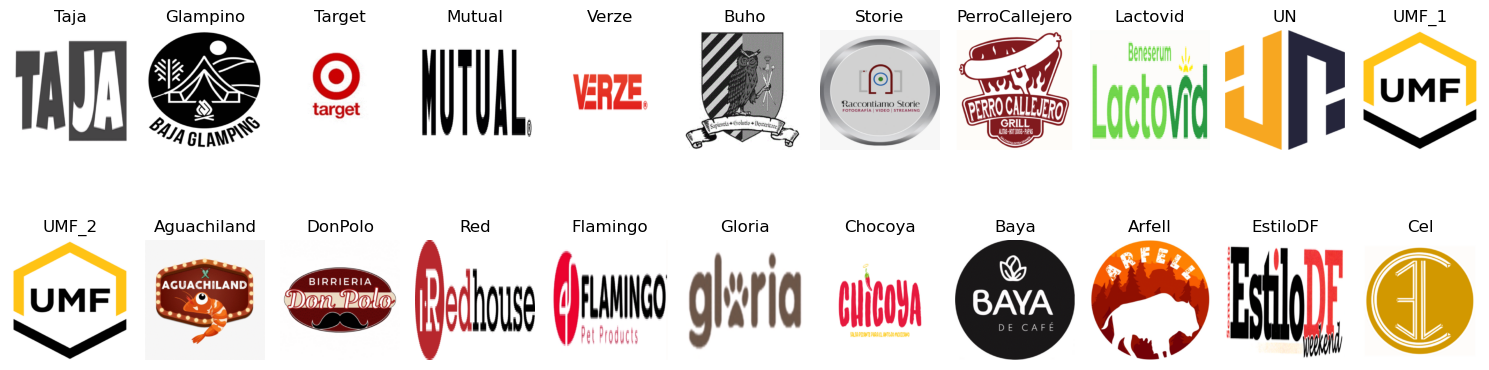

In [8]:
names = []
with open('names.txt', "r") as file:
    for line in file:
        names.append(line.strip())

fig, axs = plt.subplots(2, 11, figsize=(15, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(image_matrix_sample_RGB[i, :, :, :])
    ax.axis('off')
    ax.set_title(names[i])

fig.tight_layout()
plt.show()

### Euclidean Distance for RGB images
First we will draw the Euclidean distance for the images with three dimensions

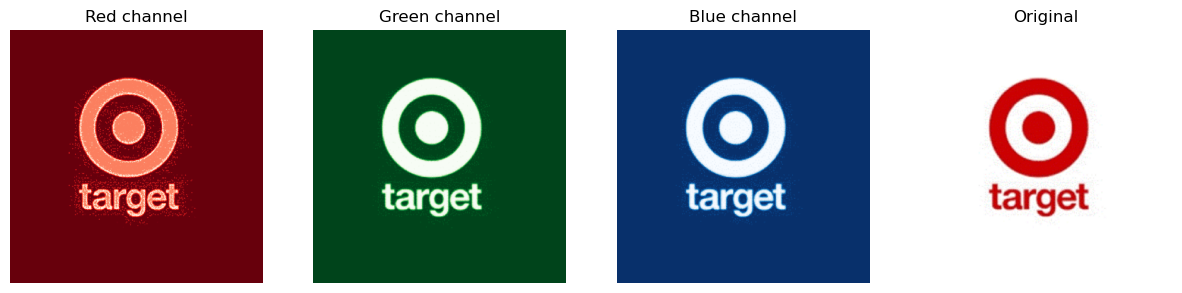

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(image_matrix_sample_RGB[2, :, :, 0], cmap='Reds')
axs[0].set_title('Red channel')
axs[0].axis('off')

axs[1].imshow(image_matrix_sample_RGB[2, :, :, 1], cmap='Greens')
axs[1].set_title('Green channel')
axs[1].axis('off')

axs[2].imshow(image_matrix_sample_RGB[2, :, :, 2], cmap='Blues')
axs[2].set_title('Blue channel')
axs[2].axis('off')

axs[3].imshow(image_matrix_sample_RGB[2, :, :, :])
axs[3].set_title('Original')
axs[3].axis('off')

plt.show()

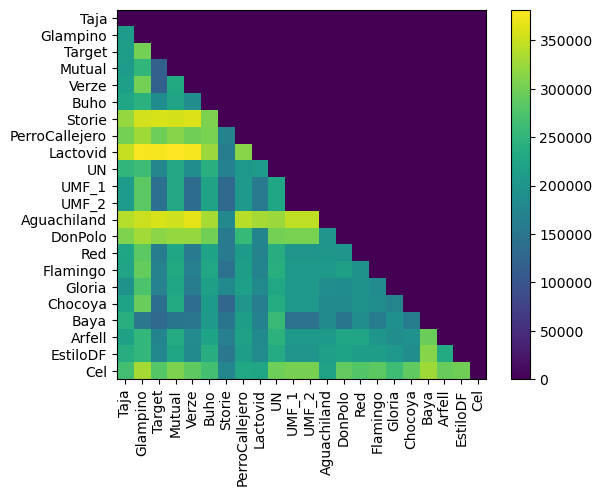

In [10]:
eu_matrix_RGB = getEuclideanDistance(image_matrix_sample_RGB)

fig, ax = plt.subplots()
im = ax.imshow(eu_matrix_RGB)

ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation= 90)
ax.set_yticklabels(names)

cbar = ax.figure.colorbar(im, ax=ax)

plt.show()

### Euclidean Distance for L images
 The "L" mode stands for Luminance, which is a grayscale mode where each pixel is represented by a single value that indicates the brightness or intensity of the pixel.

In [11]:
image_matrix_sample_L = getImgFromDirectory(directory= "img_sample", image_size= (1000, 1000), convert= "L")

print("Image matrix shape:", image_matrix_sample_L.shape)

Image matrix shape: (22, 1000, 1000)


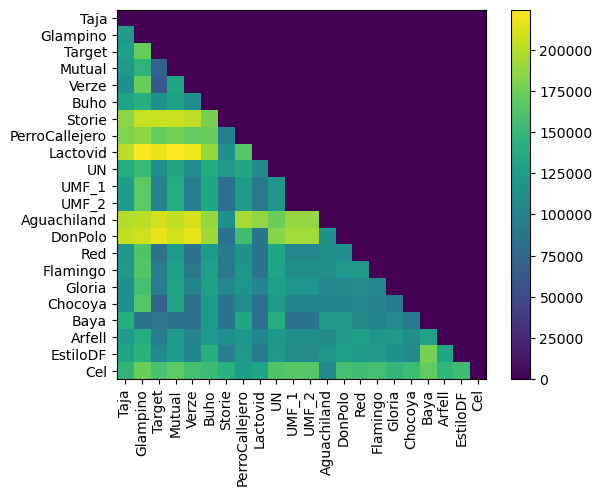

In [12]:
eu_matrix_L = getEuclideanDistance(image_matrix_sample_L)

fig, ax = plt.subplots()
im = ax.imshow(eu_matrix_L)

ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation= 90)
ax.set_yticklabels(names)

cbar = ax.figure.colorbar(im, ax=ax)

plt.show()